# Bootstrapping

Bootstrapping is a method of building up a theoretical population from a sample dataset. This is done by resampling your original sample dataset (size N) with replacement (data points can be picked multiple times) to create a new sample (also size N). Sample metrics can be computed on this new dataset. This process is repeated multiple times to get a distribution of the sample statistic.

In [19]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
plt.style.use('seaborn')

In this example, we will be using the training values from the Richter scale prediction dataset which was collected via survey in Nepal after a major earthquake. Let us assume that the whole dataset is the actual population data, and a smaller random sample is our sample data.

In [37]:
SEED = 42
DATA_DIR = 'data/'

df = pd.read_parquet(f'{DATA_DIR}train_values.parquet')
df=df.set_index('building_id')
df_sample = df.sample(n=1000, random_state=SEED)
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


Here we can see that the mean and standard deviation of the sample data is very close to the population

In [38]:
age_mean = df['age'].mean()
age_sample_mean = df_sample['age'].mean()

age_std = df['age'].std(ddof=0)
age_sample_std = df_sample['age'].std()

print(f'Age\nPopulation Mean:{age_mean}\nSample Mean:{age_sample_mean}')
print(f'Age\nPopulation Std. Dev:{age_std}\nSample Std. Dev:{age_sample_std}')

Age
Population Mean:26.535028645323695
Sample Mean:25.515
Age
Population Std. Dev:73.5657953759027
Sample Std. Dev:71.39437605254305


The function below creates a bootstrap distribution from a column of data. It resamples the column with replacement (same size) and then computes the mean. It is repeated multiple times and then returns the distribution of means.

In [39]:
# Generating a bootstrap distribution

def bootstrap(X, n=1000):
    boot_distn = []
    for i in tqdm(range(n)):
        boot_distn.append(
            X.sample(frac=1, replace=True).mean()
        )
    return boot_distn

100%|██████████| 5000/5000 [00:00<00:00, 6131.12it/s]


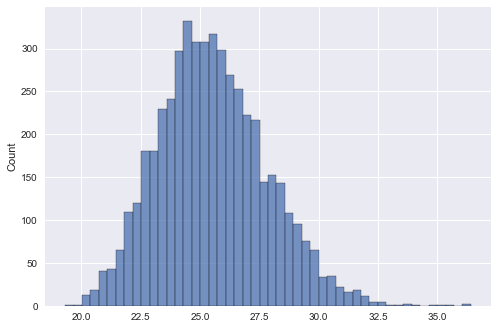

In [40]:
age_boot_distn = bootstrap(df_sample['age'], 5000)
sns.histplot(age_boot_distn)
plt.show()

The bootstrap mean is closer to the sample mean than the true population mean. The standard error is the standard deviation of the bootstrap distribution. To approximate the standard deviation of the population:

$\sigma_{pop}$ $\approx$ std_error * $\sqrt{N_{sample}}$

In [41]:
print(f'Age\nTrue Population Mean:{age_mean}\nSample Mean:{age_sample_mean}\
        \nBootstrap Mean:{np.mean(age_boot_distn)}')

Age
True Population Mean:26.535028645323695
Sample Mean:25.515        
Bootstrap Mean:25.534901


In [42]:
std_error = np.std(age_boot_distn, ddof=1)
print(f'Age\nPopulation Std. Dev:{age_std}\nSample Std. Dev:{age_sample_std}\
        \nBootstrap Std. Dev:{std_error*np.sqrt(df_sample.shape[0])}')

Age
Population Std. Dev:73.5657953759027
Sample Std. Dev:71.39437605254305        
Bootstrap Std. Dev:71.89735997429429


## Getting the confidence intervals

Using the bootstrap distribution and quantiles, we can determine the range wherein we can expect 95% of values in the population will fall into.

In [43]:
low, high = np.quantile(age_boot_distn, 0.025), np.quantile(age_boot_distn, 0.975)

print(f'95% of the buildings are between {low} and {high} years old.')

95% of the buildings are between 21.50975 and 30.270124999999997 years old.
